R² = 0.5921004968777499


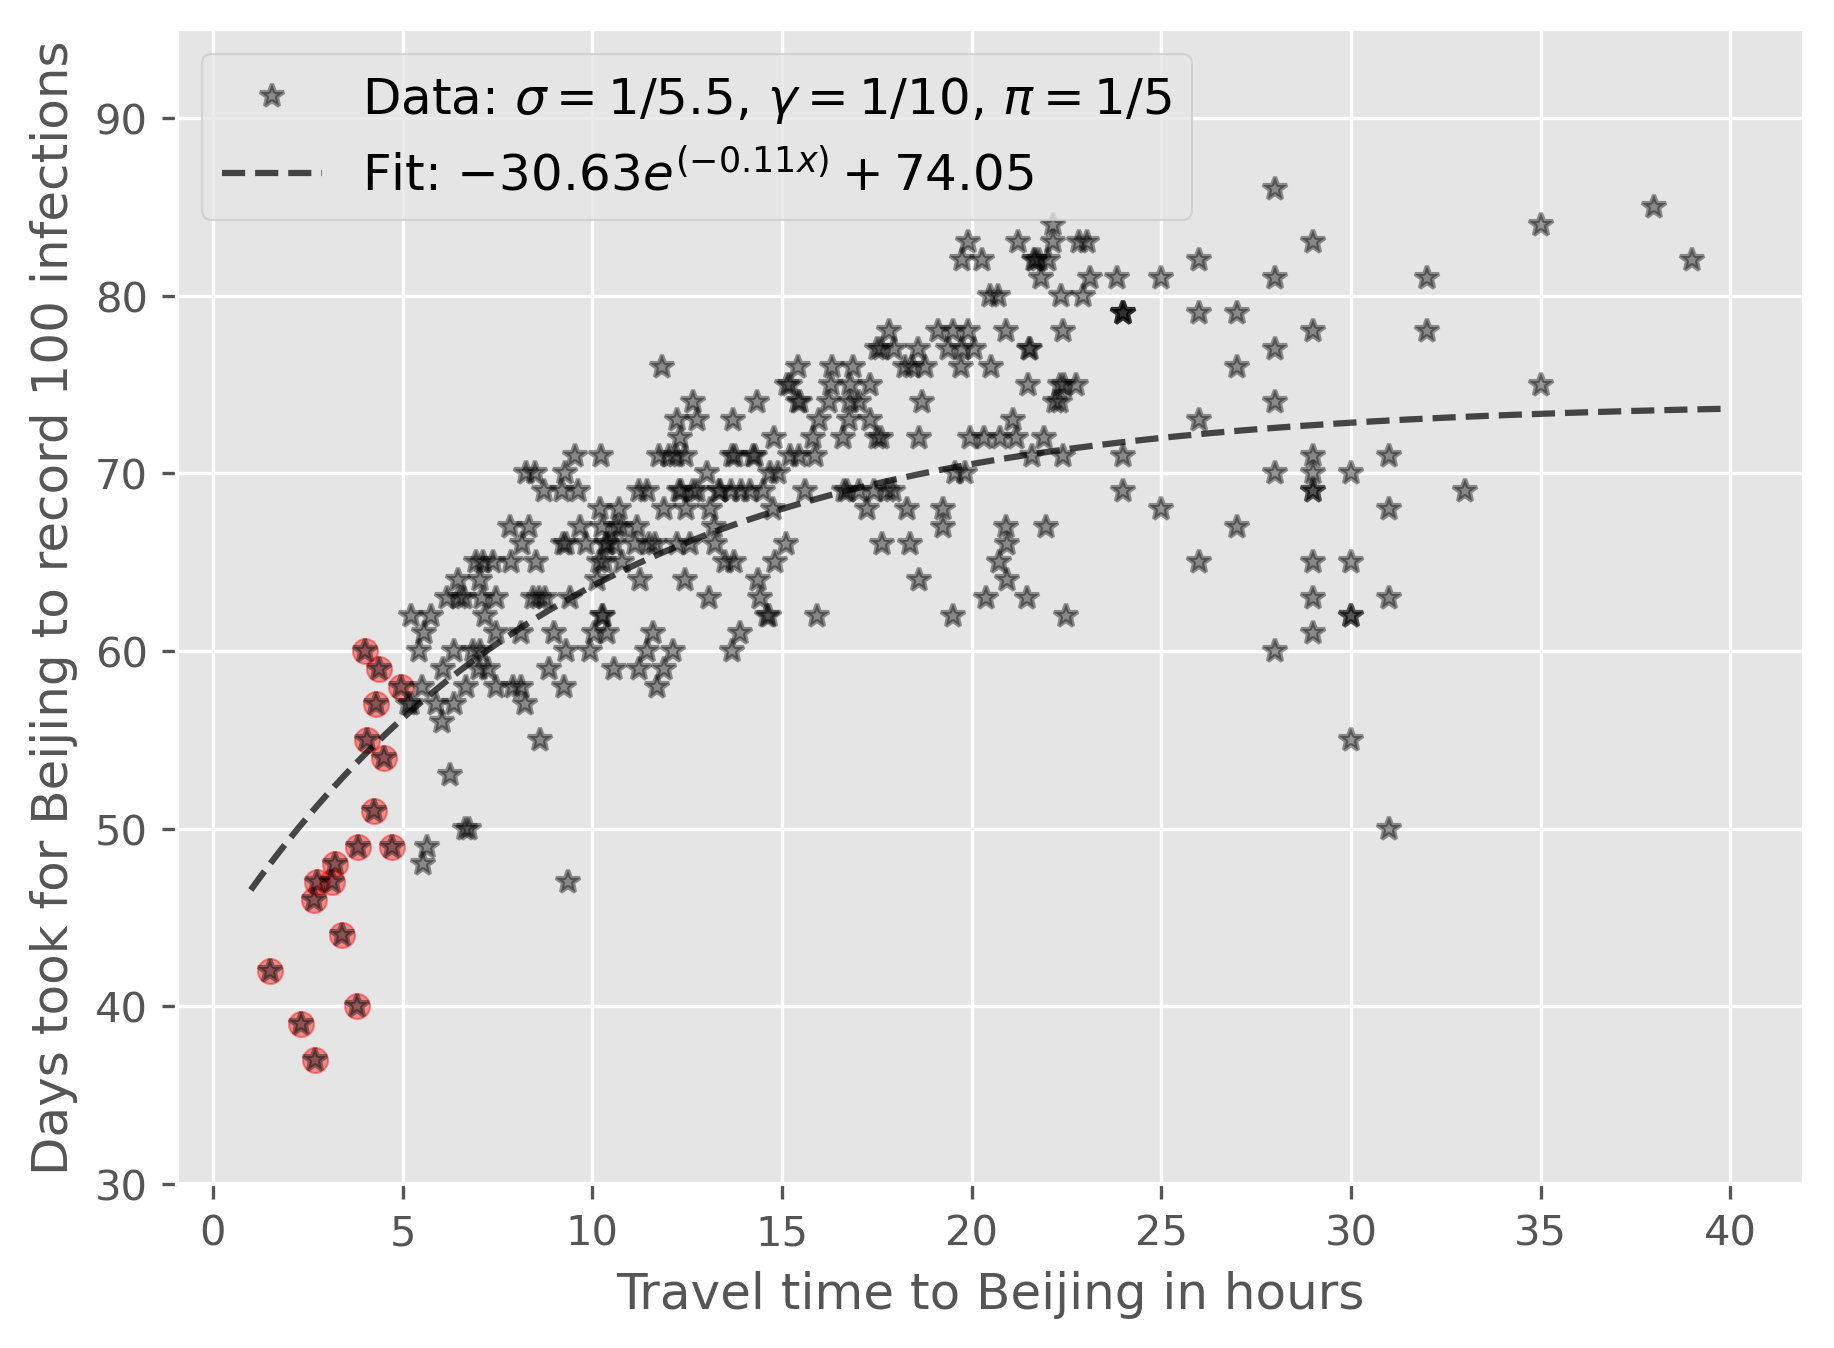

In [1]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd


df = pd.read_csv('./data/Beijing_100_infections_time_with_out_interventions_recovery_time_10_days_r0_3.csv',
 index_col='100_initial_infections_at', usecols= ['100_initial_infections_at', 'Beijing_100_infections_time'])
df.rename(columns={'Beijing_100_infections_time': 'R_0 3'}, inplace=True)


df_tt =pd.read_csv('./data/travel_time.csv', index_col='Location', usecols= ['Location', 'Total_route_length_m', 'travel_time_S'])
df_wt_tt = pd.merge(df, df_tt, left_index=True, right_index=True)
df_tt_google = pd.read_csv('./data/travel_time_google_map.csv')
df_tt_google['travel_time_S_Google'] = (df_tt_google['Hour']*3600) + (df_tt_google['Min']*60)
df_tt_google = df_tt_google[['Location','travel_time_S_Google']]
df_tt_google = df_tt_google.set_index('Location')
df_tt_google_OSM = pd.merge(df_wt_tt, df_tt_google, left_index=True, right_index=True)

df_tt_Gmap= pd.merge(df_tt, df_tt_google, left_index=True, right_index=True)

df_wt_tt = pd.merge(df, df_tt_Gmap, left_index=True, right_index=True)
df_srt = df_wt_tt.sort_values(by=['travel_time_S_Google'], ascending=True)
df_srt['travel_time_S_Google'] = df_srt['travel_time_S_Google']/3600



def ExpDecay(x, a, b, c):
    return a * np.exp(-b * x) + c
#x = np.array(range(0,len(df_srt)))
x = np.linspace(1, 40, num=len(df_srt))
#x = np.array(df_srt['travel_time_S_Google'])
#name = 'Xingtaishi_130500'
y = np.array(df_srt['R_0 3'])
df_srt = df_srt.set_index('travel_time_S_Google')
p0 = (20, .1, 50) # start with values near those we expect
params, fit = curve_fit(ExpDecay, x, y, p0, maxfev = 5000)
a, b, c = params

# determine quality of the fit
squaredDiffs = np.square(y - ExpDecay(x, a, b, c))
squaredDiffsFromMean = np.square(y - np.mean(y))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
df_srt['R_0 3 fit'] =  ExpDecay(x, a, b, c)

y_list = ['R_0 3']#, 'R_0 4', 'R_0 5']
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5] #[W,H]
plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')


#fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3,1]})
ax = df_srt.plot(
    y=y_list,
    #x='travel_time_S_Google',
    style="*",
    c='k',
    alpha = 0.4,
    #title=r"x-axis sorted by travel time to Beijing  with $\sigma = 1/5.5$, $\gamma = 1/10$, $\pi = 1/5$" f"fitted: $y = {a:.2f} e^{{(-{b:.2f}x)}} + {c:.2f}$",
    xlabel="Travel time to Beijing in hours",
    ylabel="Days took for Beijing to record 100 infections",
    figsize=(7, 5),
    #xlim=[start_time, end_time],
    ylim=[30.0, 95.0],
)


ax.plot(x, df_srt['R_0 3 fit'], '--k', alpha =0.7) #f"fitted: $y = {a:.2f} e^{{(-{b:.2f}x)}} + {c:.2f}$"

ax.legend([f"Data: $\sigma = 1/5.5$, $\gamma = 1/10$, $\pi = 1/5$", f"Fit: ${a:.2f} e^{{(-{b:.2f}x)}} + {c:.2f}$"], fontsize=12)
# Filter the data points with x-axis values below 5
filtered_data = df_srt[df_srt.index < 5]

# Plot the filtered data with the desired color
ax.scatter(filtered_data.index, filtered_data['R_0 3'], c='red', alpha=0.4)

plt.savefig('Beijing_records_100_infections_diff_R0_recovery_time_10_days_sort_tt_GMap.pdf', 
            metadata = {'Creator': 'Reju Sam John', 'Author': 'Reju', 'Title': 'Beijing_records_100_infections'},
           bbox_inches = 'tight', pad_inches = 0.2)
plt.show()

In [ ]:
df_srt.index

/var/folders/tt/5m471nxs2815sn_md1rbdvxdb8phhw/T/ipykernel_41747/3642358724.py:54: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row['geometry'].type == 'LineString':
/var/folders/tt/5m471nxs2815sn_md1rbdvxdb8phhw/T/ipykernel_41747/3642358724.py:56: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif row['geometry'].type == 'Polygon':


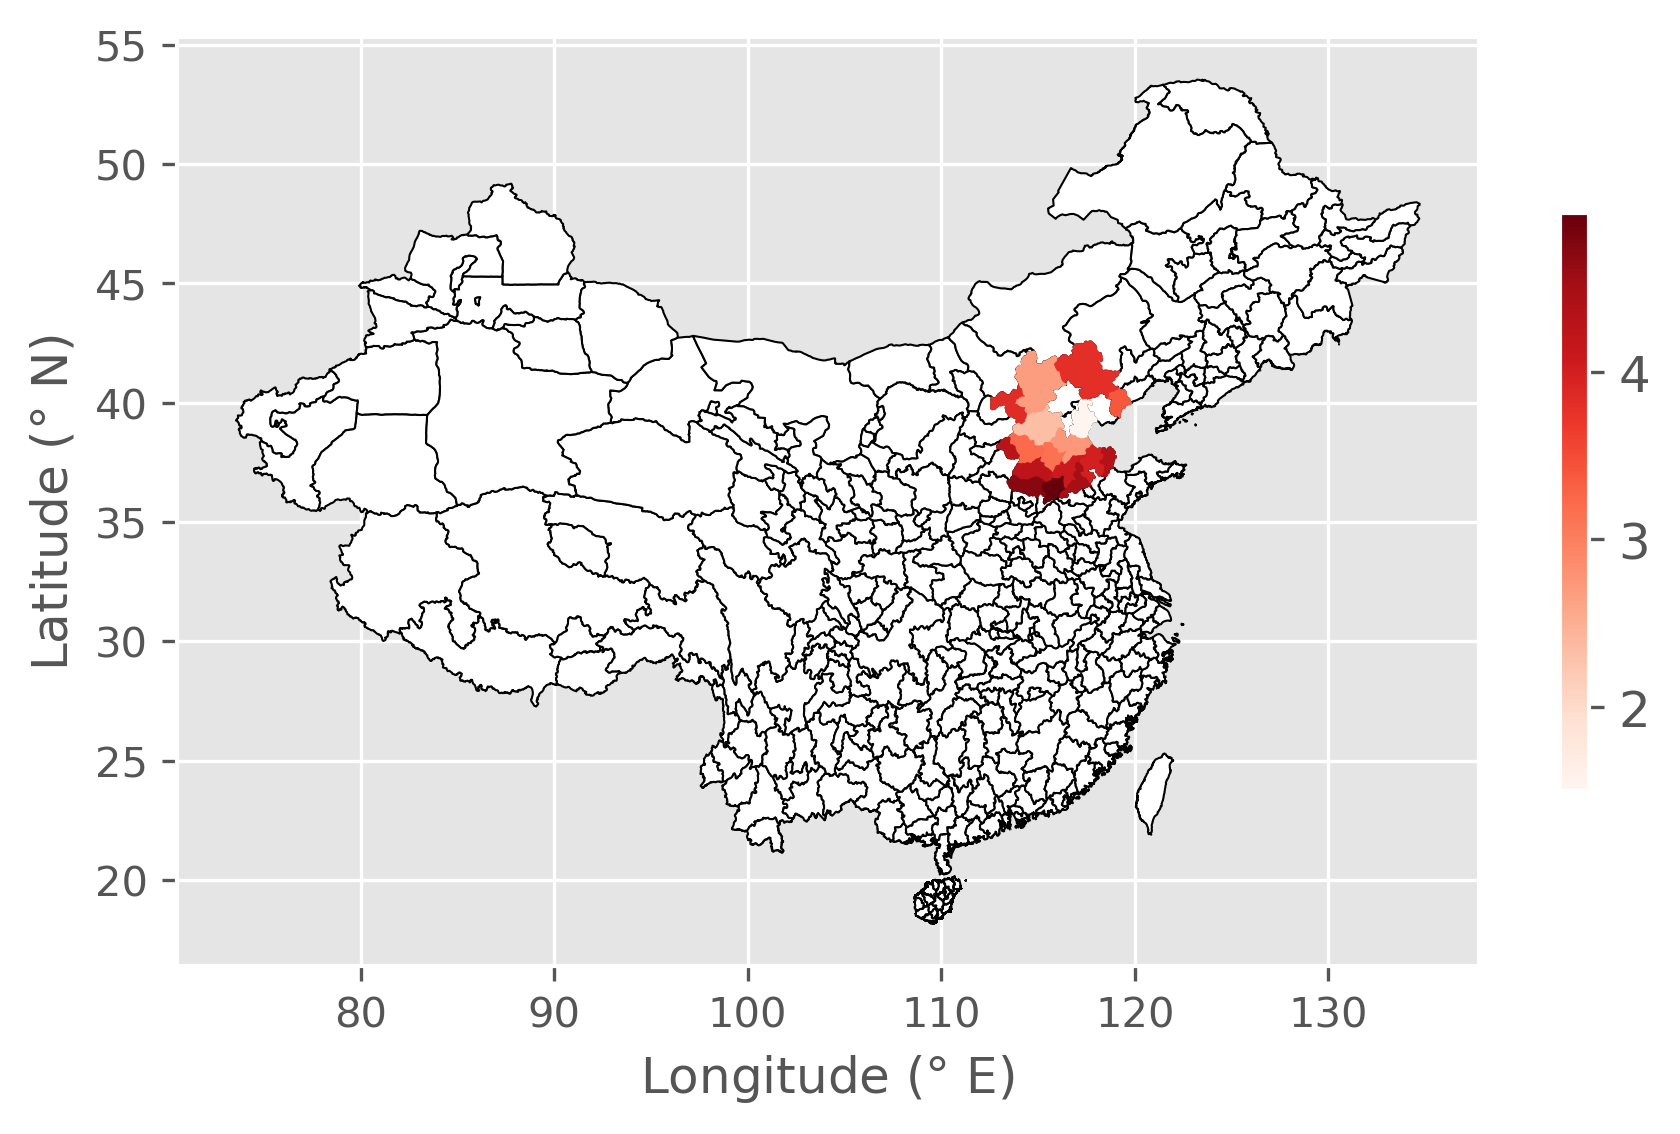

In [2]:
import geopandas as gpd
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5] #[W,H]
plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')
from matplotlib.colors import Normalize

# Read shapefile into geopandas dataframe
shapefile_path = './data/china_codes/spatial_match.shp'
gdf = gpd.read_file(shapefile_path)
gdf = gpd.GeoDataFrame(gdf[["GB_Code", "pop_2020", "ADM2_EN", "geometry"]])

df = pd.read_csv('./data/Beijing_100_infections_time_with_out_interventions_recovery_time_10_days_r0_3.csv',
 index_col='100_initial_infections_at', usecols= ['100_initial_infections_at', 'Beijing_100_infections_time'])
df.rename(columns={'Beijing_100_infections_time': 'R_0 3'}, inplace=True)

df_tt =pd.read_csv('./data/travel_time.csv', index_col='Location', usecols= ['Location', 'Total_route_length_m', 'travel_time_S'])
df_wt_tt = pd.merge(df, df_tt, left_index=True, right_index=True)
#df_srt = df_wt_tt.sort_values(by=['travel_time_S'], ascending=True)
#sort by Google Maps
df_tt_google = pd.read_csv('./data/travel_time_google_map.csv')
df_tt_google['travel_time_S_Google'] = (df_tt_google['Hour']*3600) + (df_tt_google['Min']*60)
df_tt_google = df_tt_google[['Location','travel_time_S_Google']]
df_tt_google = df_tt_google.set_index('Location')
df_tt_google_OSM = pd.merge(df_wt_tt, df_tt_google, left_index=True, right_index=True)

df_srt = df_tt_google_OSM.sort_values(by=['travel_time_S_Google'], ascending=True)
df_srt['travel_time_S_Google'] = df_srt['travel_time_S_Google']/3600

# Create a list of values for highlighting
df_tt_G_less_5 = df_srt[df_srt['travel_time_S_Google'] < 5]
name_GB_Code = list(df_tt_G_less_5.index)
GB_Code_list = [x.split('_')[1] for x in name_GB_Code]
travel_time_S_Google = list(df_tt_G_less_5['travel_time_S_Google'])

# Create a dictionary of colors for each value in the list
colors = {}
norm = Normalize(vmin=min(travel_time_S_Google), vmax=max(travel_time_S_Google))
for value in travel_time_S_Google:
    colors[value] = plt.cm.Reds(norm(value))

# Set plot parameters
fig, ax = plt.subplots(figsize=(7, 5))

# Plot geopandas dataframe
gdf.plot(ax=ax, color='white', edgecolor='black')

# Highlight specified values
for i, row in gdf.iterrows():
    if row['GB_Code'] in GB_Code_list:
        color = colors[travel_time_S_Google[GB_Code_list.index(row['GB_Code'])]]
        if row['geometry'].type == 'LineString':
            ax.plot(*row['geometry'].coords.xy, color=color, linewidth=2)
        elif row['geometry'].type == 'Polygon':
            x,y = row['geometry'].exterior.xy
            ax.fill(x,y, color=color)

# Add title
#ax.set_title("", fontsize=8)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, ticks=range(int(min(travel_time_S_Google)), int(max(travel_time_S_Google)+1)), shrink=0.5)
cbar.ax.tick_params(labelsize=12)


# # Add latitude and longitude labels
# ax.annotate('39°N', xy=(0.5, 0), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')
# ax.annotate('116°E', xy=(1, 0.5), xycoords='axes fraction', fontsize=10, ha='right', va='center', rotation=90)

# Remove axis ticks
# ax.set_xticks([])
# ax.set_yticks([])

# Add x and y axis labels
ax.set_xlabel(r'Longitude ($\degree$ E)')#, fontsize=12)
ax.set_ylabel(r'Latitude ($\degree$ N)')#, fontsize=12)

# Save and display the figure
plt.savefig('Beijing_reached_from_locations_travel_time_less_than_5_hours_Gmaps.pdf', 
            metadata={'Creator': 'Reju Sam John', 'Author': 'Reju', 
                      'Title': 'Beijing can be reached from locations (highlighted with color) with a travel time of less than 5 hours'},
            bbox_inches='tight', pad_inches=0.2)

# Show plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

# Load data
url = 'https://raw.githubusercontent.com/datasets/covid-19/main/data/countries-aggregated.csv'
df = pd.read_csv(url, parse_dates=['Date'])

# Define function to fit
def exponential(x, a, b, c):
    return a * np.exp(-b * x) + c

# Select data for Germany
country = 'Germany'
df_country = df[df['Country'] == country]
df_country = df_country.set_index('Date')

# Filter data to select only the R column for the last 30 days
filtered_data = df_country.iloc[-30:, :].filter(['R'])

# Define the x axis as days since the first data point
x = np.arange(len(filtered_data))

# Fit the data to the exponential function
popt, pcov = curve_fit(exponential, x, filtered_data['R'], p0=(1, 1e-6, 1))

# Create a new DataFrame with the fitted data
df_srt = pd.DataFrame({'x': x, 'y': exponential(x, *popt)})

# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the original data
ax.scatter(filtered_data.index, filtered_data['R'], color='black', alpha=0.4)

# Plot the filtered data with the desired color map
ax.scatter(filtered_data.index, filtered_data['R'], cmap=plt.cm.Reds, alpha=0.4)

# Plot the fitted function
ax.plot(x, df_srt['y'], '--k', alpha=0.7)

# Set the title and axis labels
ax.set_title(f'Exponential fit for R in {country}')
ax.set_xlabel('Date')
ax.set_ylabel('R')
plt.show()
